In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

2023-08-19 13:14:17.717954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 13:14:18.463070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


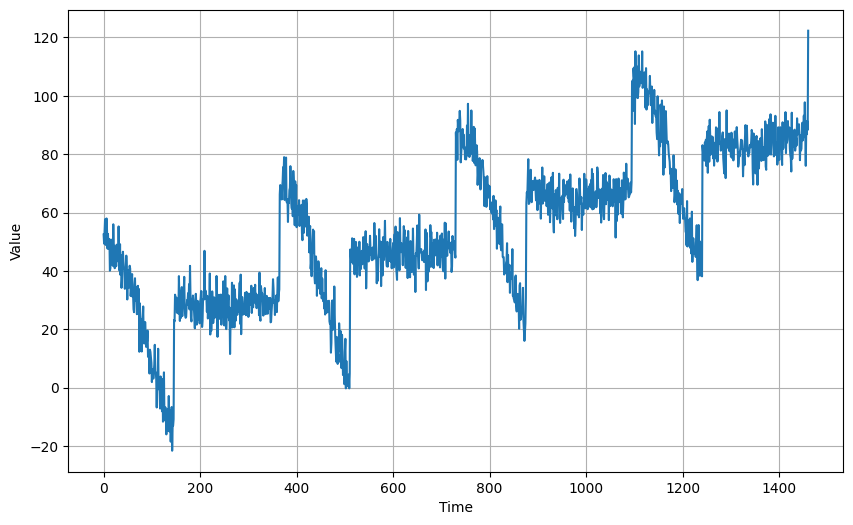

In [2]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series_noise = series + noise

plt.figure(figsize=(10, 6))
plot_series(time, series_noise)
plt.show()

In [3]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series_noise[:split_time]
time_valid = time[split_time:]
x_valid = series_noise[split_time:]

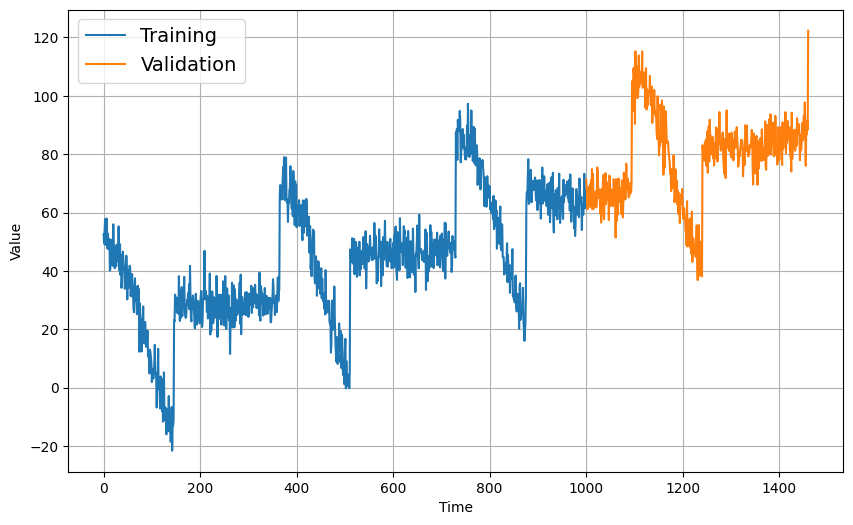

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, label='Training')
plot_series(time_valid, x_valid, label='Validation')
plt.show()

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100


2023-08-19 13:25:04.346663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:25:04.346973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 1s 7ms/step - loss: 18.9395 - mae: 19.4352 - val_loss: 8.1917 - val_mae: 8.6771
Epoch 2/100
 1/31 [..............................] - ETA: 1s - loss: 9.3042 - mae: 9.8042

2023-08-19 13:25:04.833501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:25:04.833900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 4ms/step - loss: 7.4185 - mae: 7.9042 - val_loss: 8.3215 - val_mae: 8.8086
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 7.0192 - mae: 7.5032 - val_loss: 7.3246 - val_mae: 7.8113
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 6.9845 - mae: 7.4655 - val_loss: 7.3362 - val_mae: 7.8248
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 6.8347 - mae: 7.3215 - val_loss: 7.2282 - val_mae: 7.7099
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 6.7058 - mae: 7.1881 - val_loss: 7.1866 - val_mae: 7.6730
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 6.6432 - mae: 7.1274 - val_loss: 7.0158 - val_mae: 7.5035
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 6.5967 - mae: 7.0798 - val_loss: 7.0982 - val_mae: 7.5857
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 6.5355 - mae: 7.0237 -

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2023-08-19 13:28:46.786112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:28:46.786453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 3ms/step - loss: 24.7586 - mae: 25.2570 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 12.5425 - mae: 13.0347 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 8.6636 - mae: 9.1489 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 8.6177 - mae: 9.1042 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5922 - mae: 9.0763 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5382 - mae: 9.0221 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 8.5011 - mae: 8.9870 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4684 - mae: 8.9514 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 8.4402 - mae: 8.9256 - lr: 1.8478e-06
Epoch 10/

(1e-06, 0.001, 0.0, 20.0)

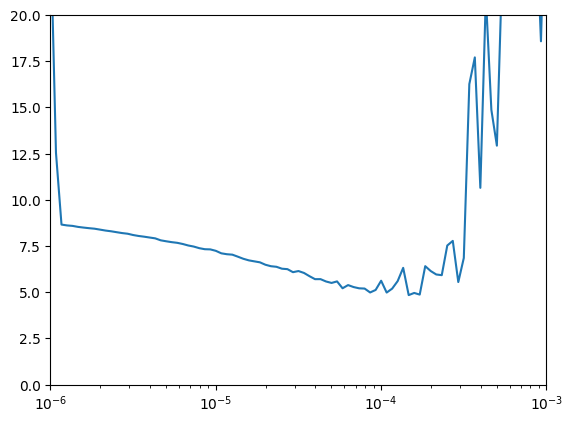

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


2023-08-19 13:30:30.345422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:30:30.345744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 1s 8ms/step - loss: 19.8702 - mae: 20.3674 - val_loss: 11.2458 - val_mae: 11.7333
Epoch 2/500


2023-08-19 13:30:30.840769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:30:30.841176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 4ms/step - loss: 10.7102 - mae: 11.1987 - val_loss: 9.5091 - val_mae: 9.9994
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 9.9427 - mae: 10.4262 - val_loss: 8.9593 - val_mae: 9.4510
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 9.4940 - mae: 9.9786 - val_loss: 8.7207 - val_mae: 9.2085
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 9.1668 - mae: 9.6532 - val_loss: 8.3418 - val_mae: 8.8238
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 8.8050 - mae: 9.2919 - val_loss: 7.9914 - val_mae: 8.4789
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 8.5144 - mae: 9.0017 - val_loss: 7.9078 - val_mae: 8.3954
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 8.3329 - mae: 8.8180 - val_loss: 7.7000 - val_mae: 8.1866
Epoch 9/500
31/31 [==============================] - 0s 4ms/step - loss: 8.0770 - mae: 8.563

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
lin_forecast = model_forecast(model, series_noise[split_time - window_size:-1], window_size)[:, 0]
lin_forecast.shape

15/15 [==============================] - 0s 4ms/step


2023-08-19 13:31:53.576178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:31:53.576512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]


(461,)

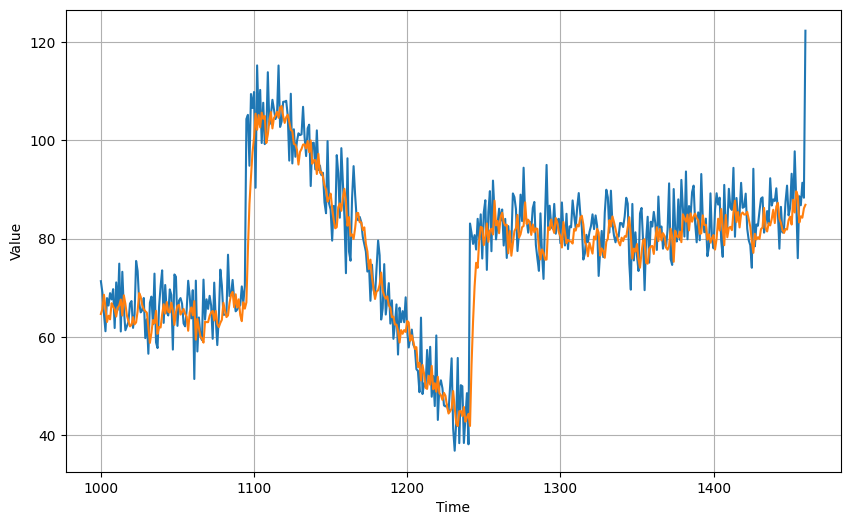

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.027709

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500


2023-08-19 13:48:15.660981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:48:15.661359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1000]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 1s 8ms/step - loss: 24.6437 - mae: 25.1397 - val_loss: 7.0540 - val_mae: 7.5337
Epoch 2/500


2023-08-19 13:48:16.419981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:48:16.420392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [461]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 0s 4ms/step - loss: 8.2749 - mae: 8.7633 - val_loss: 7.2321 - val_mae: 7.7151
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 7.3594 - mae: 7.8403 - val_loss: 6.5566 - val_mae: 7.0390
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 7.0287 - mae: 7.5123 - val_loss: 6.3282 - val_mae: 6.8159
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 6.8109 - mae: 7.2923 - val_loss: 6.2173 - val_mae: 6.7023
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 6.5914 - mae: 7.0722 - val_loss: 6.3277 - val_mae: 6.8039
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 6.4557 - mae: 6.9367 - val_loss: 6.1039 - val_mae: 6.5908
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 6.2954 - mae: 6.7750 - val_loss: 6.0644 - val_mae: 6.5492
Epoch 9/500
31/31 [==============================] - 0s 4ms/step - loss: 6.1586 - mae: 6.6387 -

In [26]:
dense_forecast = model_forecast(model, series_noise[split_time - window_size:-1], window_size)[:, 0]
dense_forecast.shape

15/15 [==============================] - 0s 3ms/step


2023-08-19 13:48:56.710384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]
2023-08-19 13:48:56.710818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [490]
	 [[{{node Placeholder/_0}}]]


(461,)

5.4509745

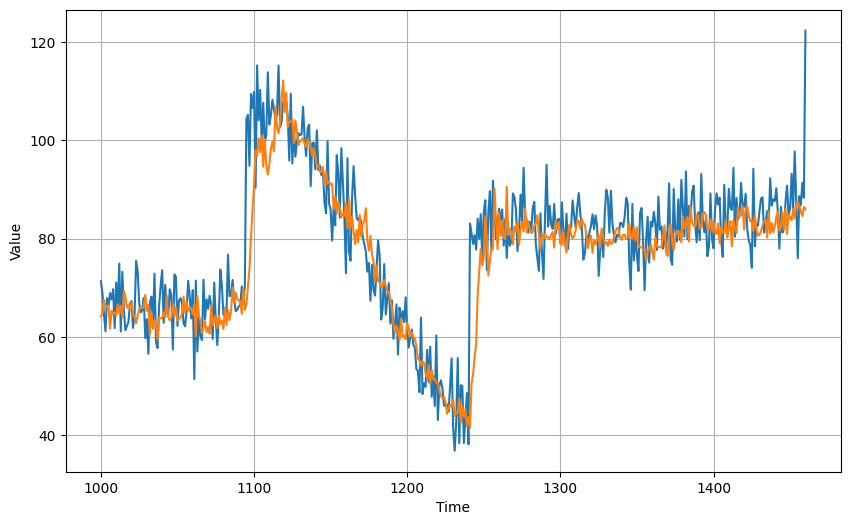

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()